# Binder selection 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bindcraft = pd.read_csv('bindcraft_passed-bindcraft_metrics.csv')

rf3 = pd.read_csv('bindcraft_passed-rf3_metrics.csv')
rf3.rename(columns={'example_id': 'Design'}, inplace=True)
rf3['Design'] = rf3['Design'].str.rsplit('_',n=1).str[0]

df = pd.merge(bindcraft, rf3, on='Design', how='outer')
df['rf3_iptm'] = df[['iptm.iptm_0','iptm.iptm_1','iptm.iptm_2','iptm.iptm_3','iptm.iptm_4']].mean(axis=1)

top_iptm_designs = df[(df['Average_i_pTM'] > 0.7) & (df['rf3_iptm'] > 0.7)].sort_values(by=['rf3_iptm'], ascending=False)

In [3]:
from promb import init_db
db = init_db('human-reference',9)


              *           █
▄▄▄▄    ▄▄▄  ▄█▄   ▄▄▄▄   █▄▄▄  
█   █  █    █▓███  █ █ █  █   █ 
█▄▄▄▀  █    ▀███▀  █   █  █▄▄▄▀ 
█                              
▀  protein mutation burden v1.0.2
                                
Loading promb database to memory...


Database (~11M peptides, <512 MB) loaded in 11s.


In [5]:
humanness_scores = []
for seq in top_iptm_designs['Sequence']:
    score = db.compute_peptide_content(seq)
    humanness_scores.append(score)
    
top_iptm_designs['humanness_score'] = humanness_scores

In [6]:
key_metrics = [
    'Design',
    'Length',
    'Helicity',
    'MPNN_score',
    'MPNN_seq_recovery',
    'Average_pLDDT',
    'Average_pTM',
    'Average_i_pTM',
    'Average_pAE',
    'Average_i_pAE',
    'Average_i_pLDDT',
    'Average_ss_pLDDT',
    'Average_Unrelaxed_Clashes',
    'Average_Relaxed_Clashes',
    'Average_Binder_Energy_Score',
    'Average_Surface_Hydrophobicity',
    'Average_ShapeComplementarity',
    'Average_PackStat',
    'Average_dG',
    'Average_dSASA',
    'Average_dG/dSASA',
    'Average_n_InterfaceResidues',
    'Average_Binder_pLDDT',
    'Average_Binder_pTM',
    'Average_Binder_pAE',
    'Average_Binder_RMSD',
    'rf3_iptm',
    'humanness_score',
    'Sequence'
]


top_iptm_designs_key_metrics = top_iptm_designs[key_metrics]
top_iptm_designs_key_metrics.to_csv('top_iptm_designs_key_metrics_peptides.csv', index=False, header=True)

## Plots

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})
plt.xlabel('Average_i_pTM (AF2-multimer)')
plt.ylabel('rf3_iptm (RF3)')
plt.plot(df['Average_i_pTM'], df['rf3_iptm'], 'o')
#plt.title('all_bindcraft_passed')

Text(0.5, 1.0, 'Top ipTM designs')

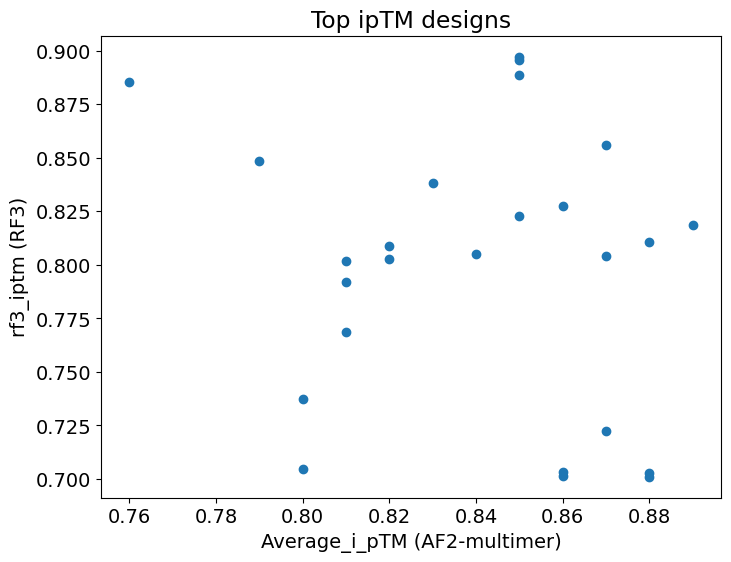

In [7]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 14})
plt.xlabel('Average_i_pTM (AF2-multimer)')
plt.ylabel('rf3_iptm (RF3)')
plt.plot(top_iptm_designs['Average_i_pTM'], top_iptm_designs['rf3_iptm'], 'o')
plt.title('Top ipTM designs')

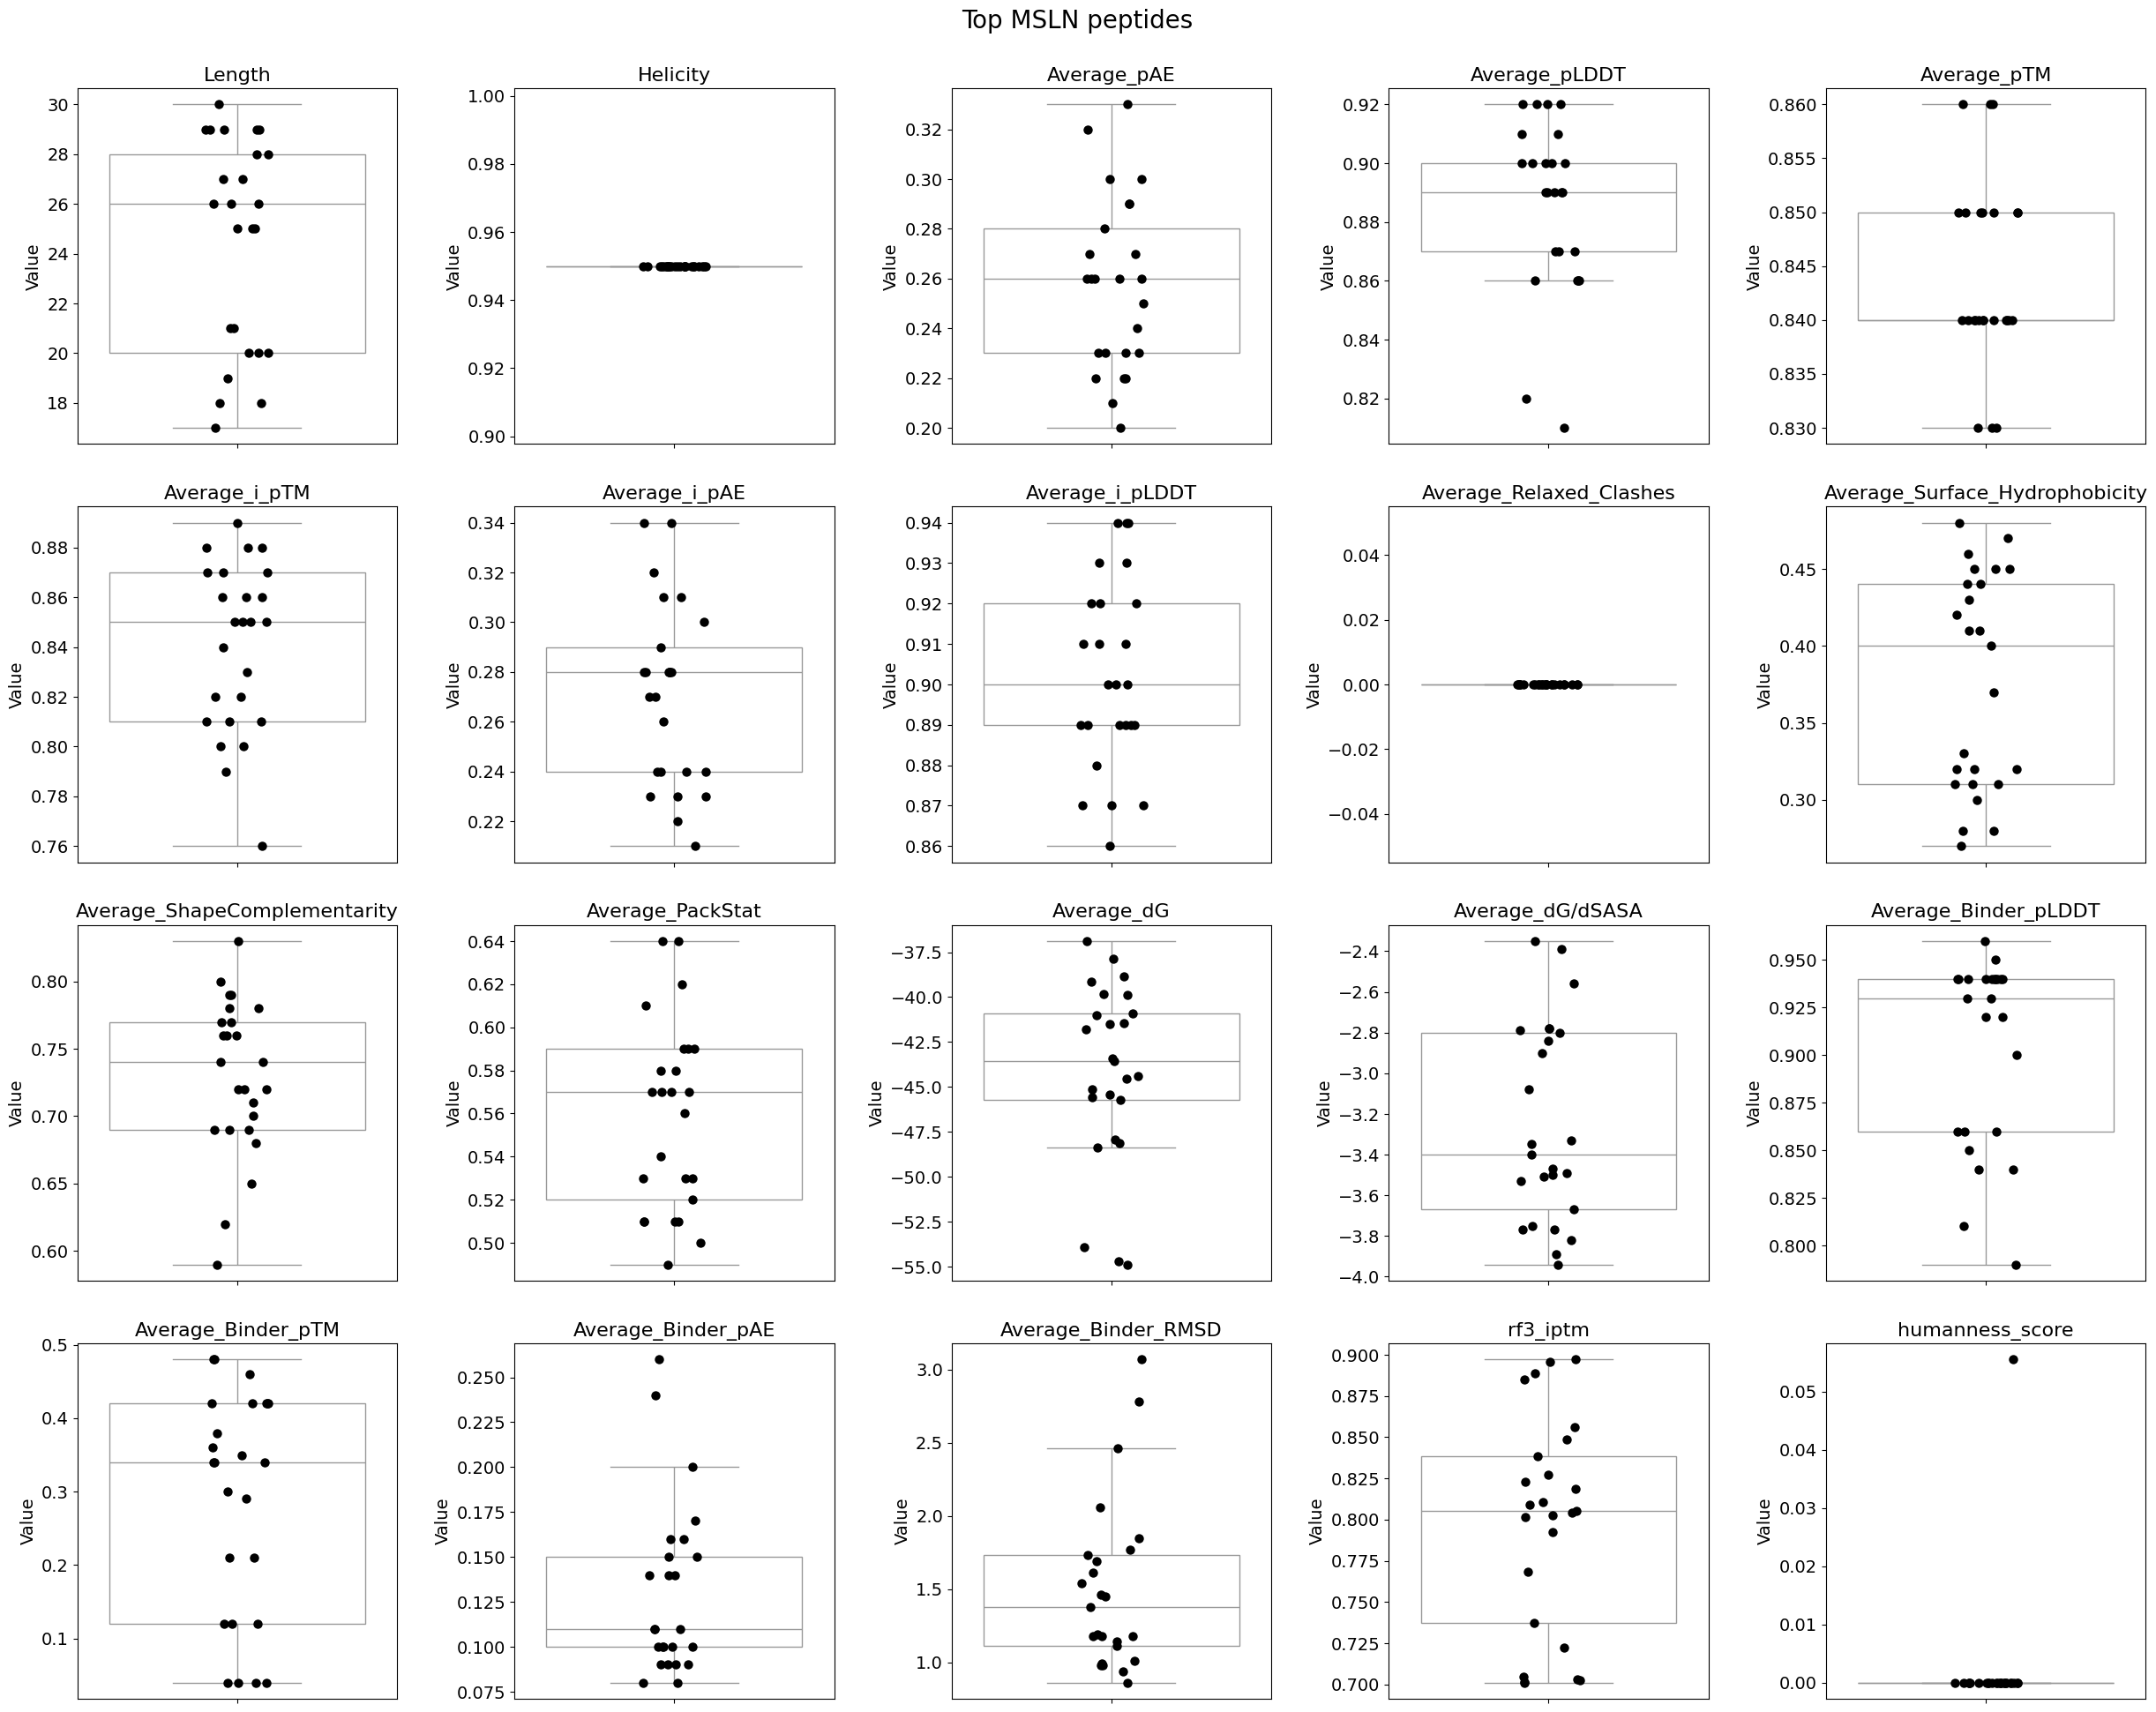

In [8]:
columns_to_plot = [
    'Length',
    'Helicity',
    'Average_pAE',
    'Average_pLDDT',
    'Average_pTM',
    'Average_i_pTM',
    'Average_i_pAE',
    'Average_i_pLDDT',
    'Average_Relaxed_Clashes',
    'Average_Surface_Hydrophobicity',
    'Average_ShapeComplementarity',
    'Average_PackStat',
    'Average_dG',
    'Average_dG/dSASA',
    'Average_Binder_pLDDT',
    'Average_Binder_pTM',
    'Average_Binder_pAE',
    'Average_Binder_RMSD',
    'rf3_iptm',
    'humanness_score'
]


num_cols = 5
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Create a violin plot for each column
for i, column in enumerate(columns_to_plot):
    sns.boxplot(y=top_iptm_designs_key_metrics[column], ax=axes[i], color='white', showfliers=False)
    sns.stripplot(y=top_iptm_designs_key_metrics[column], ax=axes[i], color='black', size=7.5, jitter=True, alpha=1)
    axes[i].set_title(column, fontsize=16)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Value', fontsize=14)

# Remove any unused subplots
for i in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout to prevent subplot titles from overlapping
fig.suptitle('Top MSLN peptides', fontsize=20)
plt.tight_layout(pad=2.0)
plt.savefig('top_iptm_designs_key_metrics_boxplots_peptides.png', dpi=300)